In [21]:
from myfunctions import *

In [1]:
#라이브러리 로드
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from colorsys import rgb_to_hsv
from keras.preprocessing.image import load_img

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
from PIL import Image

## 0. 상숫값 및 경로 설정

In [3]:
image_dir = 'images/' #1.이미지 불러오기 - 이미지 폴더 디렉토리
seed = 211012
sample_ratio = 1 #1.이미지 불러오기 - 샘플링 비율
pca_threshold = 0.99 #3. PCA - 적합한 차원 수 찾기
save_dir = 'saves1/' #6. 데이터 저장 - 데이터 저장 디렉토리

## 1. 이미지 불러오기

In [4]:
# 파일명을 담는 리스트
file_names = []

with os.scandir(image_dir) as files:
    for file in files:
        # .jpg .png 등 확장자명이 'g'로 끝나는 파일들 모두 읽기
        if file.name.endswith('g'):
            file_names.append(image_dir + file.name)
            
# 샘플링 수행 ()
if sample_ratio < 1:
    file_names = random.sample(file_names, int(len(file_names) * sample_ratio))

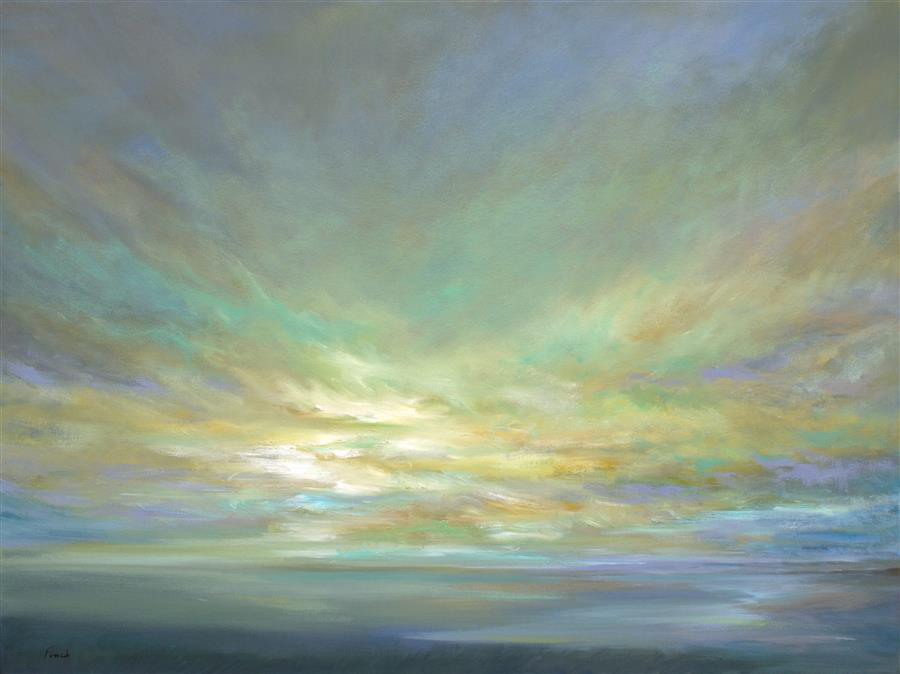

In [5]:
target_name = file_names[3]
img = load_img(target_name)
img

## 2. RGB-HSV 데이터 추출

In [6]:
def extract_data_rgbhsv(file_name, image_size = (400, 400)):
    #이미지 불러오기 및 np array로 변경
    img = load_img(file_name, target_size = image_size)
    img = np.array(img)
    img = img.reshape(image_size[0] * image_size[1], 3)
    
    #hsv 데이터 추출, 병합
    hsv_data = []
    for pixel in img:
        hsv_data.append(rgb_to_hsv(pixel[0] / 255, pixel[1] / 255, pixel[2] / 255))
    return np.concatenate((img / 255, hsv_data), axis = 1)

In [7]:
def extract_data_hsvyuv(file_name, image_size = (400, 400)):
    #이미지 불러오기 및 np array로 변경
    img = cv2.imread(file_name)
    img = cv2.resize(img, image_size)
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_hsv = img_hsv.reshape(image_size[0] * image_size[1], 3)
    img_yuv = img_yuv.reshape(image_size[0] * image_size[1], 3)
    return np.concatenate((img_hsv, img_yuv), axis = 1)

In [8]:
def getLabel(color, colorGrid):
    newH = (int)((color[0] / 180) * colorGrid[0])
    newS = (int)((color[1] / 256) * colorGrid[1])
    newV = (int)((color[2] / 256) * colorGrid[2])
    return newH * colorGrid[1] * colorGrid[2] + newS * colorGrid[2] + newV

In [9]:
def extract_data_hsv(file_name, image_size = (224, 224), grid = 5 , cgrid = (12, 8, 8)):
    img = cv2.imread(file_names[3])
    img = cv2.resize(img, (224, 224))
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    grid_count = np.zeros([grid * 2, cgrid[0] * cgrid[1] * cgrid[2]])
    clr_data = []
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            label = getLabel(img_hsv[i][j], cgrid)

            grid_count[(int)((i / image_size[0]) * grid)][label] += 1
            grid_count[grid + (int)((i / image_size[0]) * grid)][label] += 1
    for i, grid in enumerate(grid_count):
        grid_total = grid_count[i].sum()
        clr_data.append(grid_count[i] / grid_total) 
    return clr_data

In [22]:
data = extract_data_hsvyuv(target_name)
km = KMeans(n_clusters = 20, random_state=22)
km.fit_transform(data)
#clu_data = np.concatenate((extract_data_rgbhsv(target_name), km.labels_.reshape(-1, 1)), axis = 1)

array([[ 58.91704348,  32.63270675, 128.75330673, ..., 105.1184677 ,
         30.94605725,  93.9074632 ],
       [ 64.97952527,  37.35299416, 135.75049796, ..., 111.19720013,
         26.89310292, 101.42294181],
       [ 61.41229996,  36.64665462, 132.21391384, ..., 108.11119646,
         30.09168865,  98.30825097],
       ...,
       [ 98.85862154,  62.76117105, 164.36175233, ..., 136.58661634,
         35.69472637, 130.76783368],
       [103.67135292,  70.40094449, 170.7390166 , ..., 142.35313839,
         39.96663246, 138.50727772],
       [103.14629219,  70.69272201, 171.35837228, ..., 143.00377234,
         39.30492814, 139.23410311]])

In [27]:
def show_image_with_clusters(file_name, labels, image_size = (400, 400)):
    plt.figure(figsize = (25,25))
    img = load_img(file_name, target_size = image_size)
    img = np.array(img)
    for idx in range(20):
        img_now = img.copy()
        new_labels =  np.array(list(map(lambda x: x == idx, labels))).reshape(400, -1)
        for i, row in enumerate(img):
            for j, col in enumerate(row):
                if new_labels[i][j]:
                    img_now[i][j] = [0, 255, 0] #For Green
        plt.subplot(5, 4 ,idx+1);
        plt.imshow(img_now)
        plt.axis('off')    

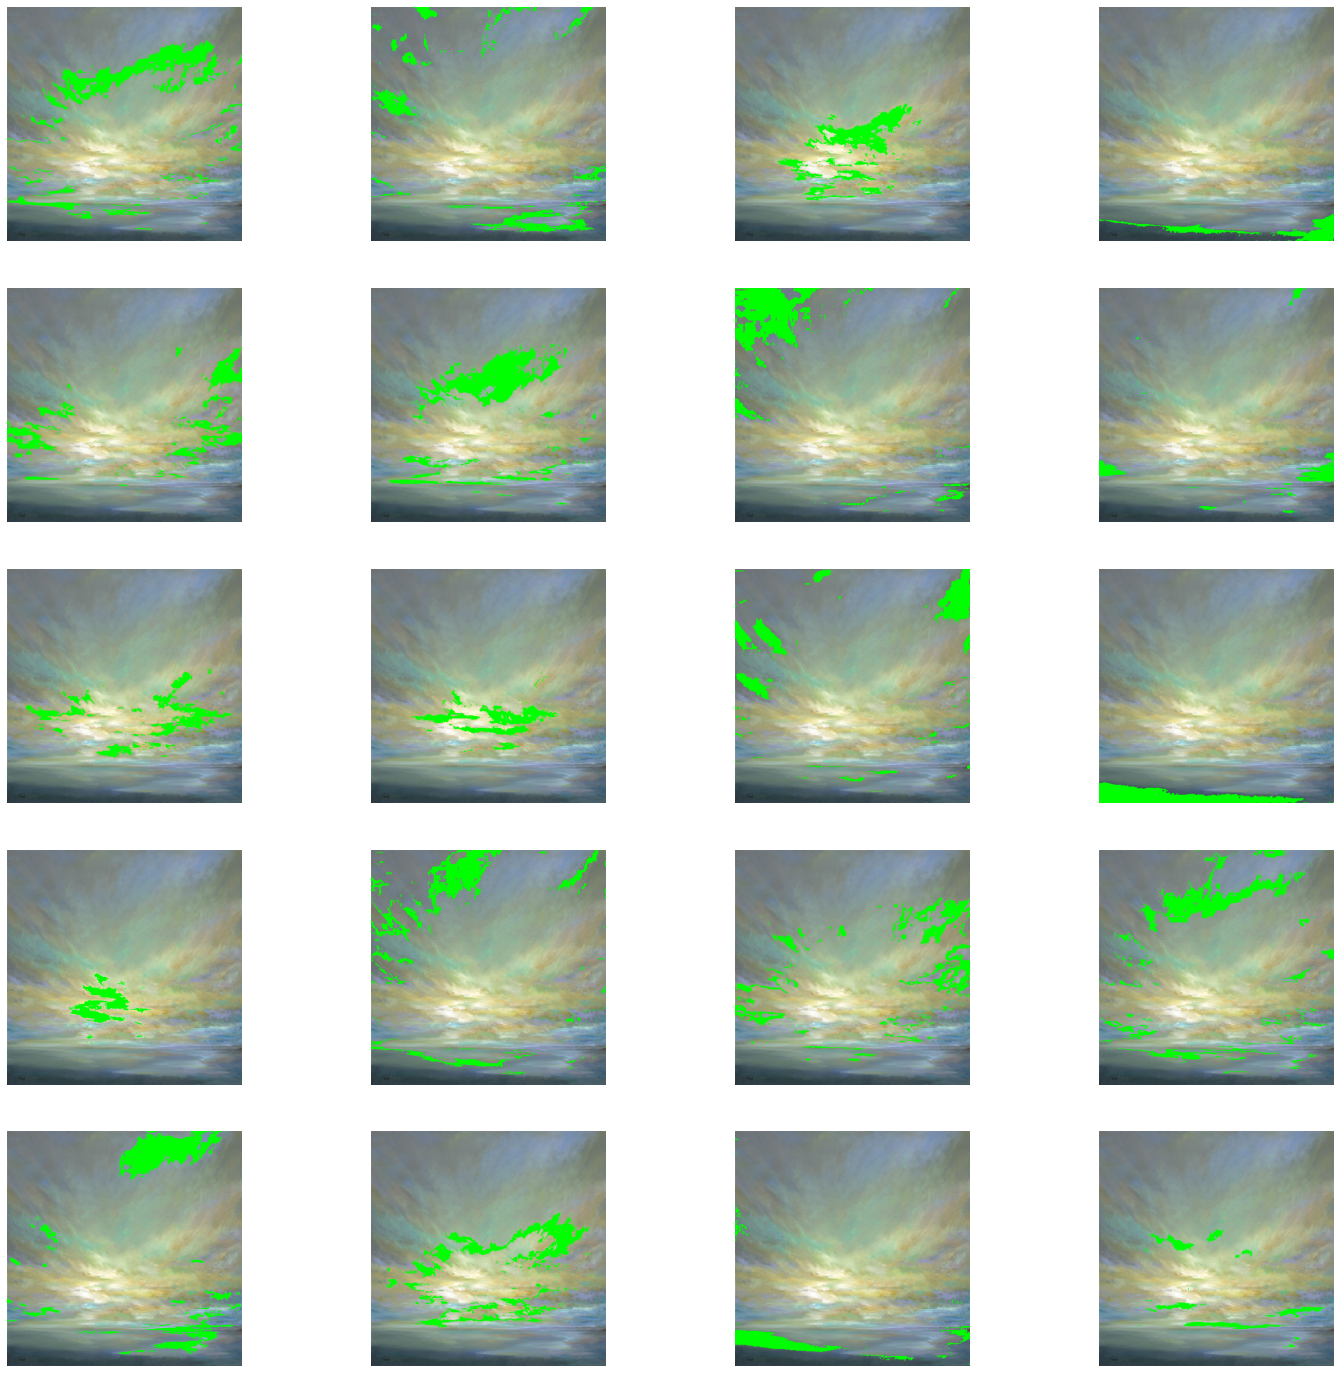

In [28]:
show_image_with_clusters(target_name, km.labels_)

In [33]:
def show_image_with_grid(file_name, labels, image_size = (400, 400)):
    plt.figure(figsize = (25,25))
    img = load_img(file_name, target_size = image_size)
    img = np.array(img)
    new_labels =  labels.reshape(400, -1)
    grid_count = np.zeros([64, 30])
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            grid_num = (int)(i / 80) * 5 + (int)(j / 80)
            grid_count[grid_num][new_labels[i][j]] += 1
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            grid_num = (int)(i / 80) * 5 + (int)(j / 80)
            if grid_count[grid_num][new_labels[i][j]] < 78:
                img[i][j] = [0, 255, 0] #For Green
    plt.imshow(img)
    plt.axis('off')    

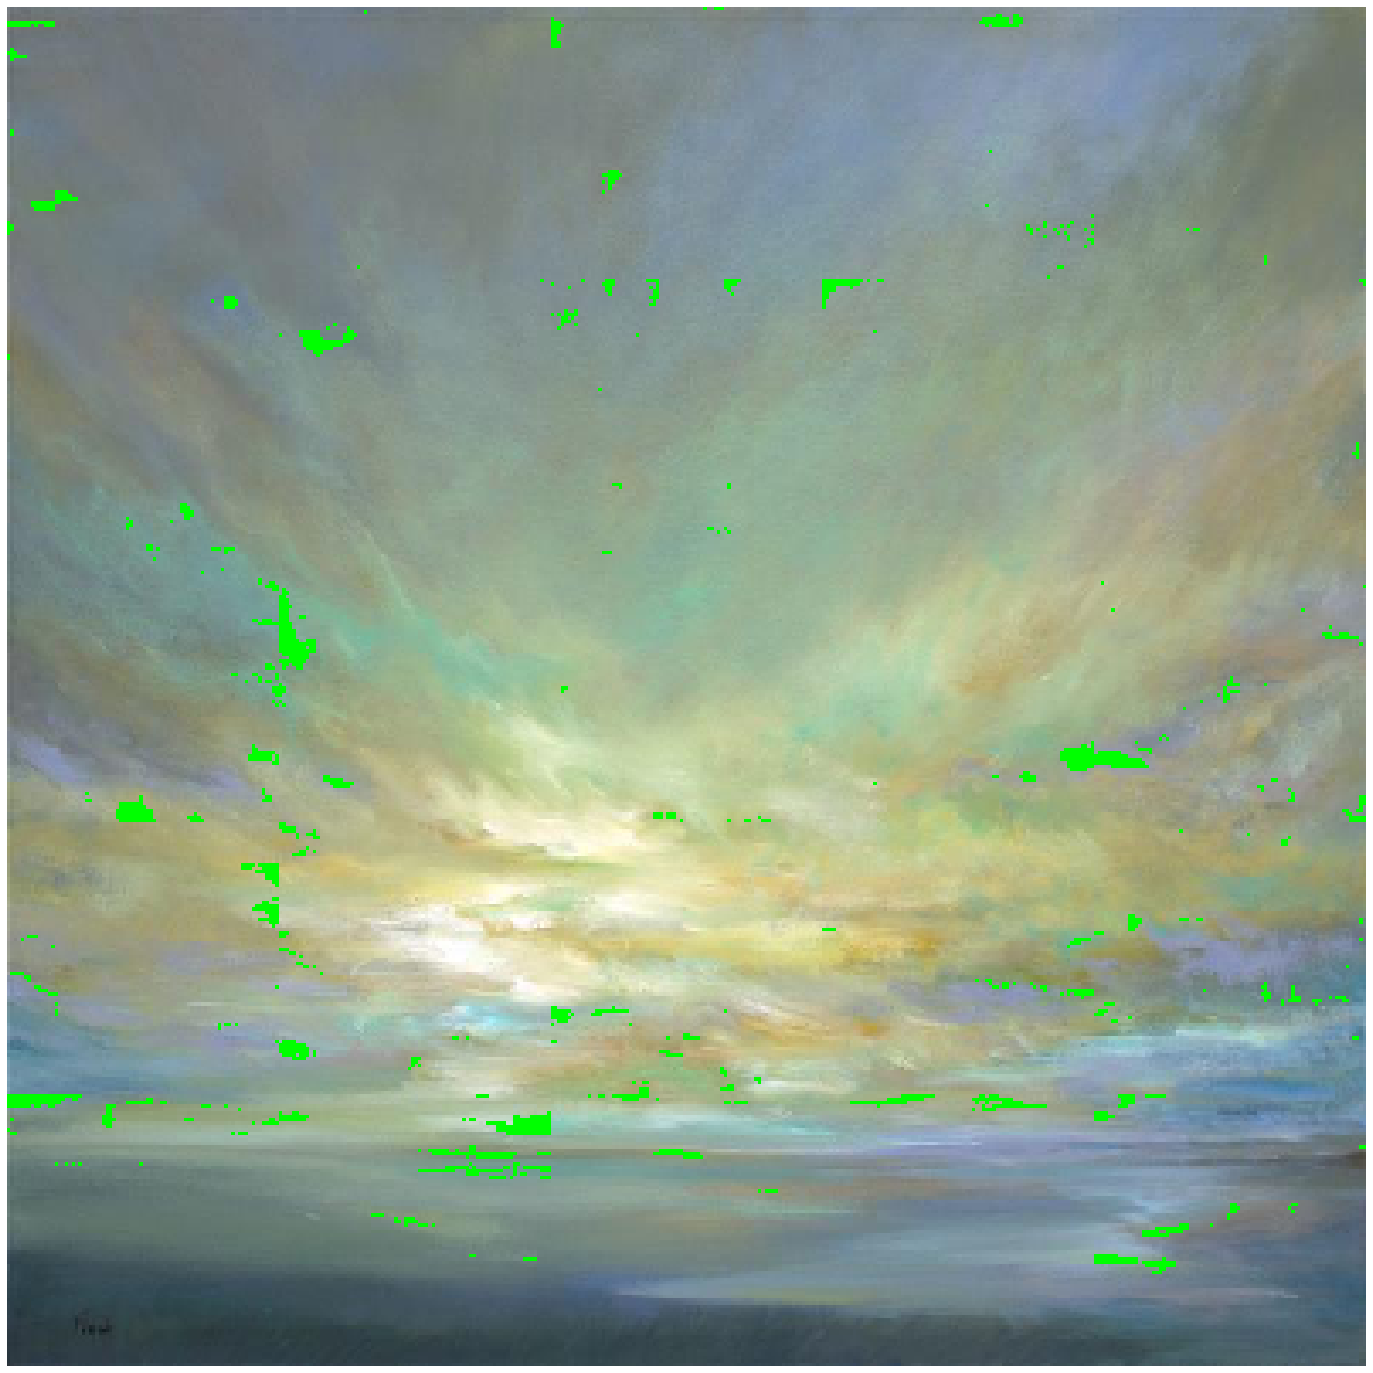

In [34]:
show_image_with_grid(target_name, km.labels_)

In [35]:
def expand_data(file_name, labels, grid = 5, image_size = (400,400)):
    img = load_img(file_name, target_size = image_size)
    img = np.array(img)
    new_labels =  labels.reshape(400, -1)
    grid_data = np.zeros([grid * 2, 30, 3])
    grid_count = np.zeros([grid * 2, 30])
    clr_data = []
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            grid_data[(int)(i / 80)][new_labels[i][j]] += img[i][j]
            grid_count[(int)(i / 80)][new_labels[i][j]] += 1
            grid_data[grid + (int)(j / 80)][new_labels[i][j]] += img[i][j]
            grid_count[grid + (int)(j / 80)][new_labels[i][j]] += 1
    for i, grid in enumerate(grid_data):
        grid_total = grid_count[1].sum()
        for j, clu in enumerate(grid_data[i]):
            if grid_count[i][j] > 0:
                now = np.append(grid_data[i][j] / grid_count[i][j], grid_count[i][j] / grid_total)
                clr_data.append(now)
    return np.array(clr_data)

In [39]:
clr_data = expand_data(target_name, km.labels_)
clr_table = pd.DataFrame(clr_data, columns = ['R', 'G', 'B', 'Count'])
clr_table

,R,G,B,Count
0,136.563041,152.492782,138.850818,0.032469
1,118.382727,133.332310,143.877685,0.071281
2,132.000000,142.666667,113.666667,0.000094
3,143.000000,169.000000,166.000000,0.000031
4,115.279798,123.823913,127.016589,0.254312
...,...,...,...,...
175,138.347633,150.588018,153.323225,0.042250
176,131.015895,150.810988,170.729440,0.090438
177,171.489307,176.776410,141.320804,0.048219
178,96.307438,108.894215,116.028099,0.018906


In [40]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
def save_data(data, file_name, save_dir):
    createFolder(save_dir)
    try:
        save_name = save_dir + file_name.rsplit('.')[0].rsplit('/')[-1] + ".csv"
        data.to_csv(save_name)
    except:
        print ('Error: Creating Data. ' + save_name)

In [41]:
save_data(clr_table, target_name, save_dir)

## 8. 전체 데이터셋 수행

In [42]:
for file_name in tqdm(file_names):
    save_name = save_dir + file_name.rsplit('.')[0].rsplit('/')[-1] + ".csv"
    if not os.path.isfile(save_name):
        try:
            data = extract_data_hsvyuv(file_name)
            km = KMeans(n_clusters = 20, random_state=22)
            km.fit_transform(data)
            clr_data = expand_data(file_name, km.labels_)
            clr_table = pd.DataFrame(clr_data, columns = ['R', 'G', 'B', 'Count'])
            save_data(clr_table, file_name, save_dir)
        except:
            print("Error Detected at : " + file_name)

100%|███████████████████████████████████████████████████████████████████████████| 5411/5411 [12:52:49<00:00,  8.57s/it]
